<a href="https://colab.research.google.com/github/Hamoda-dabbit/ocr_deepLearning/blob/main/Copy_of_Untitled2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

استيراد المكتبات

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import os
import random
import numpy as np
from scipy.sparse import csr_matrix
import pandas as pd
import json

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns 
import matplotlib.cm as cm
from matplotlib import rcParams
from prettytable import PrettyTable

import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem.isri import ISRIStemmer
from collections import Counter 
import itertools
import re
import string

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

from joblib import dump, load

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**استيراد قاعدة البيانات**

In [ ]:
df = pd.read_csv("drive/MyDrive/mining/arabic_dataset_classifiction.csv")

df

,text,targe
0,بين أستوديوهات ورزازات وصحراء مرزوكة وآثار ولي...,0
1,قررت النجمة الأمريكية أوبرا وينفري ألا يقتصر ع...,0
2,أخبارنا المغربية الوزاني تصوير الشملالي ألهب ا...,0
3,اخبارنا المغربية قال ابراهيم الراشدي محامي سعد...,0
4,تزال صناعة الجلود في المغرب تتبع الطريقة التقل...,0
...,...,...
111723,اللاعب تأخر في العودة إلى التداريب والمدرب غاض...,4
111724,المشرف العام لحسنية أكادير قال إنه سيغادر الفر...,4
111725,نسب إليه نتائج الوداد وصحوة الرجاء وآخر صيحاته...,4
111726,ستحتضن الرباط في الفترة مابين يوليوز المقبل دو...,4


حذف الأسطر التي لا تحوي على صنف في قاعدة البيانات

In [ ]:
print(np.sum(df.isnull().any(axis=1)))

clean_df = df.dropna()
print(np.sum(clean_df.isnull().any(axis=1)))

2939
0


In [ ]:
print (df.notnull().any(axis = 0))

text     True
targe    True
dtype: bool


-------
**تنظيف البيانات**

:يتم تنظيف البيانات على عدة مراحل

ازالة بعض الرموز


In [ ]:
def remove_hashtag(df, col = 'text'):
    for letter in r'#.][!XR':
        df[col] = df[col].astype(str).str.replace(letter,'', regex=True)
    

        
remove_hashtag(clean_df)
clean_df

,text,targe
0,بين أستوديوهات ورزازات وصحراء مرزوكة وآثار ولي...,0
1,قررت النجمة الأمريكية أوبرا وينفري ألا يقتصر ع...,0
2,أخبارنا المغربية الوزاني تصوير الشملالي ألهب ا...,0
3,اخبارنا المغربية قال ابراهيم الراشدي محامي سعد...,0
4,تزال صناعة الجلود في المغرب تتبع الطريقة التقل...,0
...,...,...
111723,اللاعب تأخر في العودة إلى التداريب والمدرب غاض...,4
111724,المشرف العام لحسنية أكادير قال إنه سيغادر الفر...,4
111725,نسب إليه نتائج الوداد وصحوة الرجاء وآخر صيحاته...,4
111726,ستحتضن الرباط في الفترة مابين يوليوز المقبل دو...,4


ازالة بعض الرموز العربية

In [ ]:
arabic_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ'''
english_punctuations = string.punctuation
punctuations_list = arabic_punctuations + english_punctuations

def remove_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

استبدال الحروف العربية التي لها أكثر من شكل في الكتابة 

In [ ]:
def normalize_arabic(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)
    return text

In [ ]:
def remove_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1', text)

**تطبيق تنظيف البيانات**

In [ ]:
def processDocument(doc, stemmer): 

    #Replace @username with empty string
    doc = re.sub(r'@[^\s]+', ' ', doc)
    doc = re.sub(r'_', ' ', doc)
    doc = re.sub(r'\n', ' ', doc)
    doc = re.sub(r'[a-z,A-Z]', '', doc)
    doc = re.sub(r'\d', '', doc)
    #Convert www.* or https?://* to " "
    doc = re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',doc)
    #Replace #word with word
    doc = re.sub(r'#([^\s]+)', r'\1', doc)
    # remove punctuations
    doc= remove_punctuations(doc)
    # normalize the tweet
    doc= normalize_arabic(doc)
    # remove repeated letters
    doc=remove_repeating_char(doc)
    #stemming
    doc = stemmer.stem(doc)
    
    return doc

stemmer = ISRIStemmer()
clean_df["text"] = clean_df['text'].apply(lambda x: processDocument(x, stemmer))
clean_df

,text,targe
0,بين استوديوهات ورزازات وصحراء مرزوكه واثار ولي...,0
1,قرت النجمه الامريكيه اوبرا وينفري الا يقتصر عم...,0
2,اخبارنا المغربيه الوزاني تصوير الشملالي الهب ا...,0
3,اخبارنا المغربيه قال ابراهيم الراشدي محامي سعد...,0
4,تزال صناعه الجلود في المغرب تبع الطريقه التقلي...,0
...,...,...
111723,اعب تاخر في العوده الي التداريب والمدرب غاضب و...,4
111724,مشرف العام لحسنيه اكادير قال انه سيغادر الفريق...,4
111725,نسب اليه نتائج الوداد وصحوه الرجاء واخر صيحاته...,4
111726,ستحتضن الرباط في الفتره مابين يوليوز المقبل دو...,4


تحويل كل مقالة (سطر) إلى مصفوفة عناصرها هي كلمات المقالة

In [ ]:
tokenizer = RegexpTokenizer(r'\w+')
clean_df["text"] = clean_df["text"].apply(tokenizer.tokenize)
# print(clean_df['text'].values[0])
clean_df

,text,targe
0,"[بين, استوديوهات, ورزازات, وصحراء, مرزوكه, واث...",0
1,"[قرت, النجمه, الامريكيه, اوبرا, وينفري, الا, ي...",0
2,"[اخبارنا, المغربيه, الوزاني, تصوير, الشملالي, ...",0
3,"[اخبارنا, المغربيه, قال, ابراهيم, الراشدي, محا...",0
4,"[تزال, صناعه, الجلود, في, المغرب, تبع, الطريقه...",0
...,...,...
111723,"[اعب, تاخر, في, العوده, الي, التداريب, والمدرب...",4
111724,"[مشرف, العام, لحسنيه, اكادير, قال, انه, سيغادر...",4
111725,"[نسب, اليه, نتائج, الوداد, وصحوه, الرجاء, واخر...",4
111726,"[ستحتضن, الرباط, في, الفتره, مابين, يوليوز, ال...",4


"stop words"حذف الكلمات الشائعة (الغير مؤثرة في المعنى)

In [ ]:
stopwords_list = stopwords.words('arabic')
listToStr = ' '.join([str(elem) for elem in stopwords_list]) 
print(listToStr)

إذ إذا إذما إذن أف أقل أكثر ألا إلا التي الذي الذين اللاتي اللائي اللتان اللتيا اللتين اللذان اللذين اللواتي إلى إليك إليكم إليكما إليكن أم أما أما إما أن إن إنا أنا أنت أنتم أنتما أنتن إنما إنه أنى أنى آه آها أو أولاء أولئك أوه آي أي أيها إي أين أين أينما إيه بخ بس بعد بعض بك بكم بكم بكما بكن بل بلى بما بماذا بمن بنا به بها بهم بهما بهن بي بين بيد تلك تلكم تلكما ته تي تين تينك ثم ثمة حاشا حبذا حتى حيث حيثما حين خلا دون ذا ذات ذاك ذان ذانك ذلك ذلكم ذلكما ذلكن ذه ذو ذوا ذواتا ذواتي ذي ذين ذينك ريث سوف سوى شتان عدا عسى عل على عليك عليه عما عن عند غير فإذا فإن فلا فمن في فيم فيما فيه فيها قد كأن كأنما كأي كأين كذا كذلك كل كلا كلاهما كلتا كلما كليكما كليهما كم كم كما كي كيت كيف كيفما لا لاسيما لدى لست لستم لستما لستن لسن لسنا لعل لك لكم لكما لكن لكنما لكي لكيلا لم لما لن لنا له لها لهم لهما لهن لو لولا لوما لي لئن ليت ليس ليسا ليست ليستا ليسوا ما ماذا متى مذ مع مما ممن من منه منها منذ مه مهما نحن نحو نعم ها هاتان هاته هاتي هاتين هاك هاهنا هذا هذان هذه هذي هذين هكذا هل هلا هم هما هن هنا هنا

In [ ]:
clean_df["text"] = clean_df["text"].apply(lambda x: [item for item in x if item not in stopwords_list])
clean_df

,text,targe
0,"[استوديوهات, ورزازات, وصحراء, مرزوكه, واثار, و...",0
1,"[قرت, النجمه, الامريكيه, اوبرا, وينفري, الا, ي...",0
2,"[اخبارنا, المغربيه, الوزاني, تصوير, الشملالي, ...",0
3,"[اخبارنا, المغربيه, قال, ابراهيم, الراشدي, محا...",0
4,"[تزال, صناعه, الجلود, المغرب, تبع, الطريقه, ال...",0
...,...,...
111723,"[اعب, تاخر, العوده, الي, التداريب, والمدرب, غا...",4
111724,"[مشرف, العام, لحسنيه, اكادير, قال, انه, سيغادر...",4
111725,"[نسب, اليه, نتائج, الوداد, وصحوه, الرجاء, واخر...",4
111726,"[ستحتضن, الرباط, الفتره, مابين, يوليوز, المقبل...",4


%تقسيم البيانات إلى مجموعة تدريب واختبار بنسبة 25

In [ ]:
y = clean_df['targe']
X = clean_df['text']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2)



Tf-idf  اختيار الميزات في النص عبر خوارزمية 

In [ ]:
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    ngram_range=(1, 1),
    max_features =10000)

**تدريب النظام**

In [ ]:
model = Pipeline([
                    ("tfidf", word_vectorizer), # convert words to numbers using tfidf
                    ("clf", SVC()) # model the text
])

# Fit the pipeline to the training data
model.fit(X_train.astype('str'), y_train)



Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=10000, strip_accents='unicode',
                                 sublinear_tf=True)),
                ('clf', SVC())])

In [ ]:
dump(model, "svm_model.joblib")

['svm_model.joblib']

حساب دقة النظام

In [ ]:
def calculate_results(y_true, y_pred):
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

y_pred = model.predict(X_test.astype('str'))
result = calculate_results(y_test, y_pred)
result

{'accuracy': 95.91514081917788,
 'f1': 0.9591878472535011,
 'precision': 0.9592865199450652,
 'recall': 0.9591514081917788}

عرض نتائج تدريب وعدد أخطاء كل صنف 

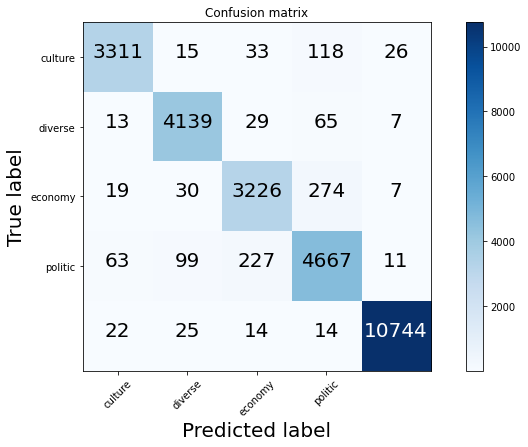

In [ ]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    fig = plt.figure(figsize = (10,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd' 
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 fontsize=20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, ['culture', 'diverse', 'economy', 'politic'])#, 'sport'])